In [208]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from datetime import date
from datetime import datetime
import calendar
import os
import re


from scipy import stats
from sklearn.neighbors import KernelDensity
import matplotlib.colors as mcolors
from matplotlib.animation import FuncAnimation, PillowWriter

import seaborn as sns
from pathlib import Path
from tqdm import tqdm_notebook, trange, tqdm
from PIL import Image, ImageDraw
import io
import random as r

from matplotlib.widgets import Slider, Button, RadioButtons
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing
# For downsampling
from sklearn.utils import resample,shuffle

np.random.seed(2021)

In [209]:
df_companies = pd.read_csv("./data/companies.csv")
df_payments = pd.read_csv("./data/payments.csv")
df_physicians = pd.read_csv("./data/physicians.csv")

c:\python38\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (26,27,28) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [210]:
df_companies

,Company_ID,Name,State,Country
0,1,Merck Sharp & Dohme Corporation,NJ,United States
1,2,"COMSORT, Inc",MD,United States
2,3,Daiichi Sankyo Company LTD,NaN,Japan
3,4,"C. R. Bard, Inc. & Subsidiaries",NJ,United States
4,5,Novartis Pharma AG,NaN,Switzerland
...,...,...,...,...
2426,2427,Amryt Pharma Holdings Ltd,NaN,Ireland
2427,2428,"Heraeus Medical Components, LLC",MN,United States
2428,2429,International Life Sciences,GA,United States
2429,2430,"Foundation Consumer Healthcare, LLC",PA,United States


In [211]:
df_companies.rename({"State":"State_Comp","Country":"Country_Comp"}, axis='columns', inplace=True)
df_physicians.rename({"State":"State_Phys","Country":"Country_Phys"}, axis='columns', inplace=True)
pd.set_option('display.max_columns', None)

In [212]:
def ownInterest(id):
    if(df_payments.query('Physician_ID==@id and Ownership_Indicator=="Yes"').shape[0]>0):
        return 1
    else:
        return 0
    
df_physicians['Ownership_Interest']=df_physicians['id'].apply(ownInterest)

In [213]:
#drop Ownership Indicators=yes records
df_scrap=df_payments.query('Ownership_Indicator=="Yes"', engine='python')
df_payments=pd.concat([df_payments, df_scrap]).drop_duplicates(keep=False)

In [214]:
#Feature Engineering
def total_pay(phys_id):
    return df_payments.query('Physician_ID==@phys_id').Total_Amount_of_Payment_USDollars.sum()

df_physicians['Total_Payments']=df_physicians['id'].apply(total_pay)

def sum_num_pay(phys_id):
    return df_payments.query('Physician_ID==@phys_id').Number_of_Payments.sum()

df_physicians['Total_Num_Payments']=df_physicians['id'].apply(sum_num_pay)

df_physicians['Value_by_Num']=df_physicians['Total_Payments']/df_physicians['Total_Num_Payments']

def num_tran(phys_id):
    return df_payments.query('Physician_ID==@phys_id').shape[0]

df_physicians['Number_Transaction']=df_physicians['id'].apply(num_tran)

df_physicians['Value_by_Tran']=df_physicians['Total_Payments']/df_physicians['Number_Transaction']



In [215]:
#Feature Engineering 2
def max_comp(phys_id):
    return df_payments.query('Physician_ID==@phys_id').Company_ID.value_counts().index[0]

df_physicians['Max_Comp_ID']=df_physicians['id'].apply(max_comp)


In [106]:
df_physicians.to_csv("./modified_physician_with_features.csv",index=False)

In [42]:
df_physicians.to_csv("./modified_physician.csv",index=False)

In [216]:
df=df_physicians

In [217]:
df['index_col'] = df.index
df=pd.wide_to_long(df, stubnames='License_State_', i=['index_col'],j='License_State_Number').reset_index()
df.drop(columns=['index_col'],inplace=True)

In [218]:
df.drop(columns=['First_Name', 'Middle_Name', 'Last_Name', 'Name_Suffix','Province','License_State_Number'], inplace=True)

In [219]:
df.dropna(subset=['License_State_'],inplace=True)

In [220]:
columns_encode=['City', 'State_Phys', 'Zipcode', 'Country_Phys','Primary_Specialty','License_State_']
for column in columns_encode:
    df[column]=df[column].astype('category')
    df[column]=df[column].cat.codes

In [221]:
df_train=df[df.set=="train"]
df_test=df[df.set=="test"]

df_train.drop(columns=['set'])
df_test.drop(columns=['set'])
df_train.shape

(7453, 15)

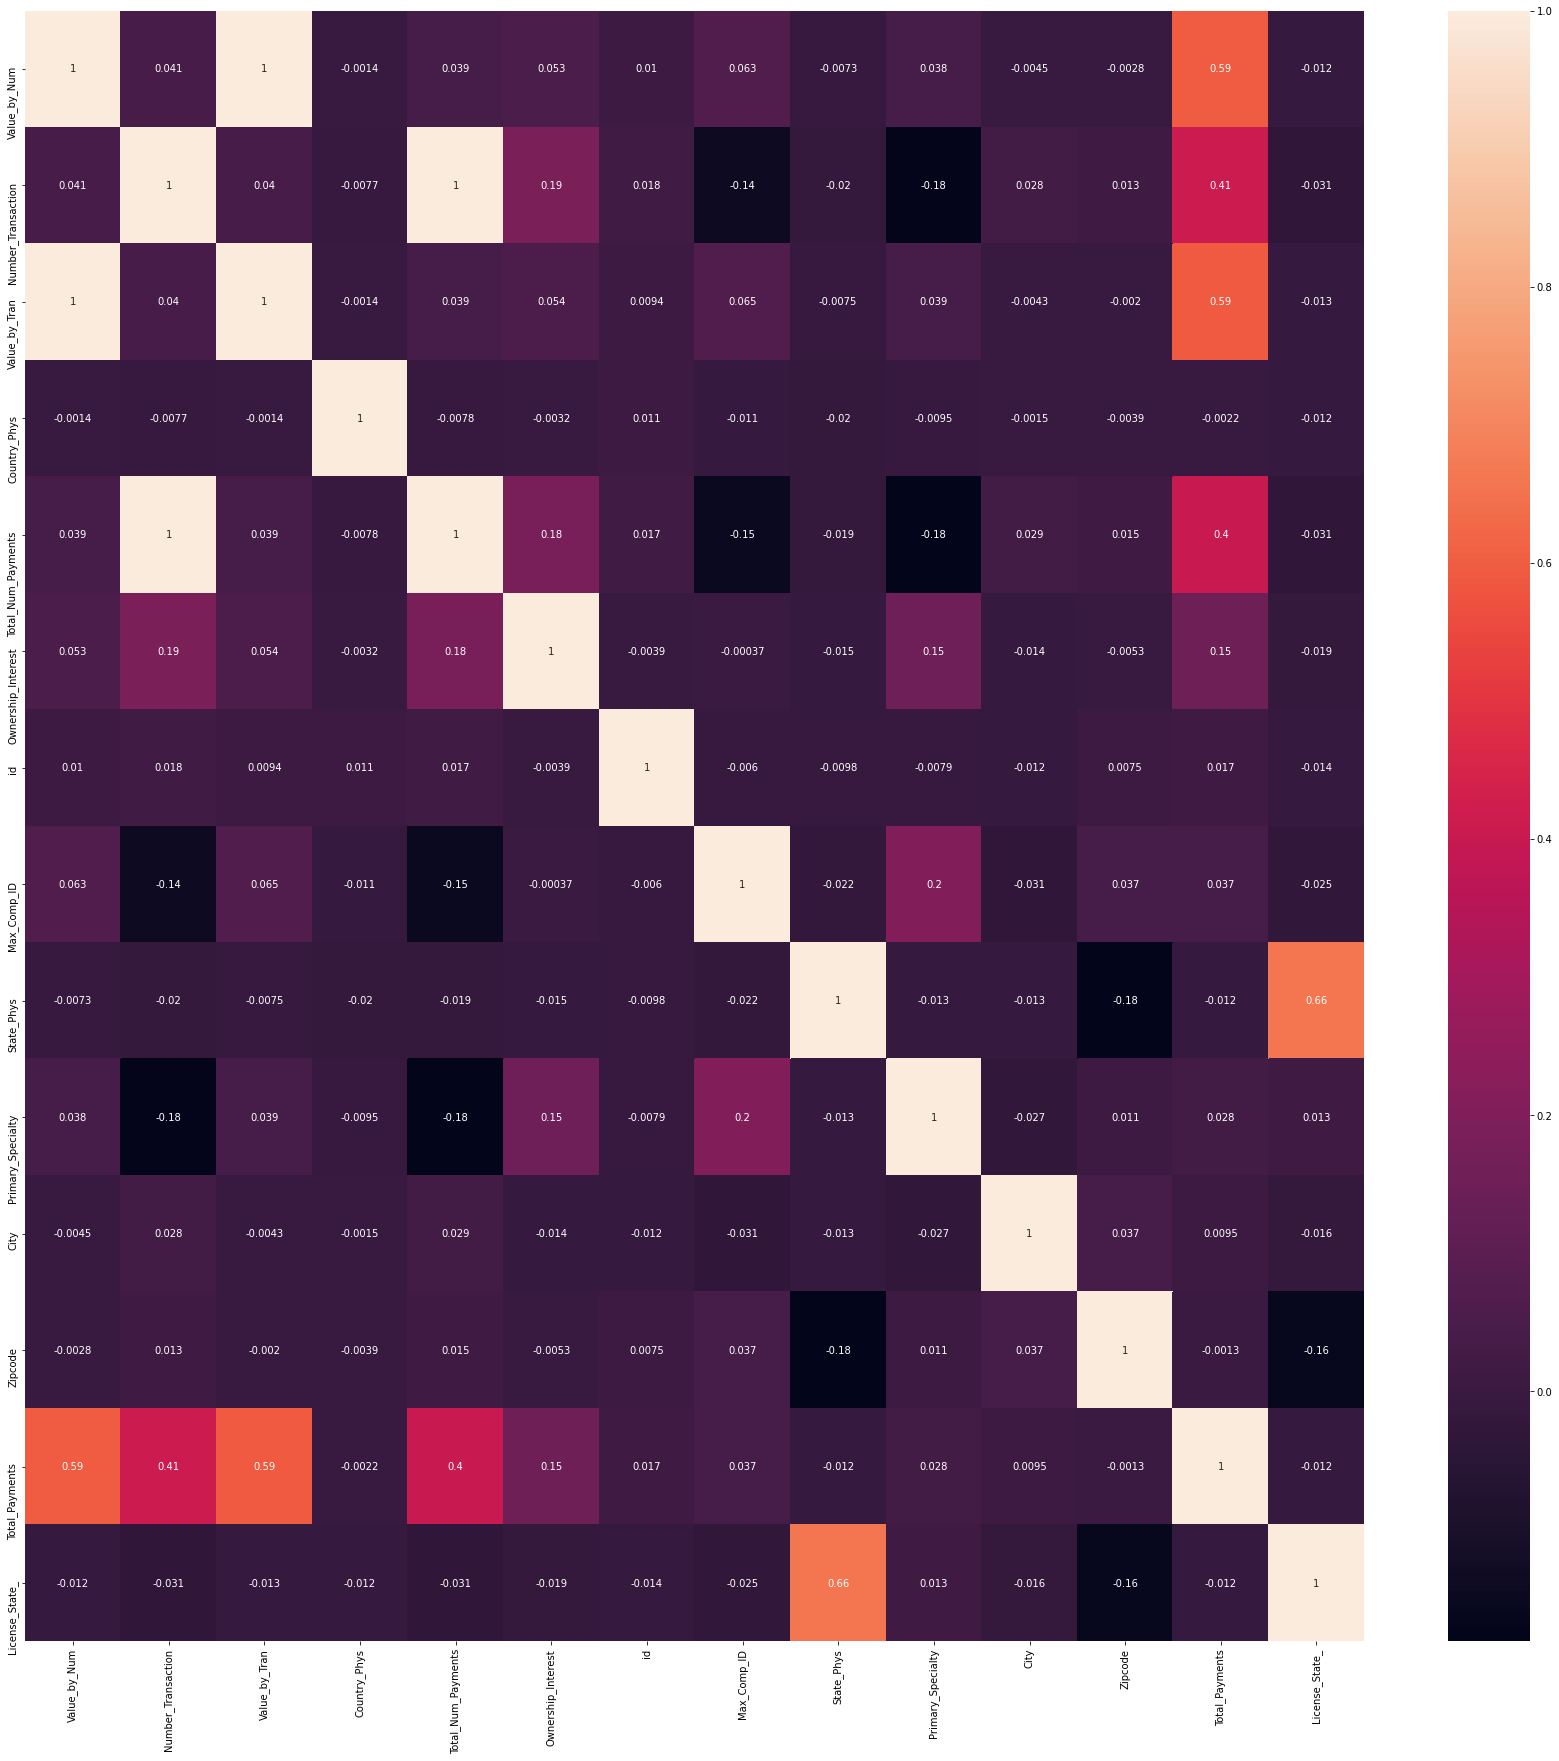

In [117]:
fig = plt.figure(figsize = (30,30))
ax = fig.gca()
# df_train.drop(columns=['set'],inplace=True)

heatmap = sns.heatmap(df_train.corr(), annot=True)
fig = heatmap.get_figure()
fig.savefig("phys_level_heatmap_after_na_encode.png")

In [222]:

###drop set column
df_test.drop(columns=['set'],inplace=True)
df_train.drop(columns=['set'],inplace=True)

##send predicted attribute to end
first_col = df_train.pop("Ownership_Interest")
df_train.insert((df_train.shape[1]),"Ownership_Interest",first_col)

first_col = df_test.pop("Ownership_Interest")
df_test.insert((df_test.shape[1]),"Ownership_Interest",first_col)

##send Physician ID to end
first_col = df_train.pop("id")
df_train.insert((df_train.shape[1]),"id",first_col)

first_col = df_test.pop("id")
df_test.insert((df_test.shape[1]),"id",first_col)


c:\python38\lib\site-packages\pandas\core\frame.py:4167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [223]:
np.random.seed(2021)
##downsampling
df_train_maj=df_train[df_train.Ownership_Interest==0]
df_train_min=df_train[df_train.Ownership_Interest==1]
df_train_maj_down=resample(df_train_maj, replace=False, n_samples=df_train_min.shape[0], random_state=2021)
df_train_final = pd.concat([df_train_maj_down, df_train_min])

###test train split of own train set
df_train_final['is_train']=np.random.uniform(0,1,len(df_train_final)) <=.80
train, test = df_train_final[df_train_final['is_train']==True], df_train_final[df_train_final['is_train']==False]
train = shuffle(train,random_state=2021)
test = shuffle(test,random_state=2021)

In [204]:
print(df_train.columns)
df_train.shape

Index(['Value_by_Num', 'Number_Transaction', 'Value_by_Tran', 'Country_Phys',
       'Total_Num_Payments', 'Max_Comp_ID', 'State_Phys', 'Primary_Specialty',
       'City', 'Zipcode', 'Total_Payments', 'License_State_',
       'Ownership_Interest', 'id'],
      dtype='object')


(7453, 14)

In [205]:
best=0
i=0
n=150
# f = open("AfterSqueezingNEstSearch.txt", "a")
# f.write("File Starts here:\n")

while n>0:
    n_est=r.randint(50,200)
    ###feature and label split
    features=train[train.columns[0:(train.shape[1]-3)]]
    y=train['Ownership_Interest']
    x_test = test[test.columns[0:(test.shape[1]-3)]]
    y_test = test['Ownership_Interest']

    ###model training
    clf = RandomForestClassifier(n_jobs=-1, oob_score = True, n_estimators = n_est, random_state=2021)
    clf.fit(features, y)
    test_acc=clf.score(x_test,y_test)
    if test_acc>best:
        best=test_acc
#         f.write('BEST:'+' '+str(test_acc)+' N_EST: '+str(n_est)+'\n')
        print('BEST:'+' '+str(test_acc)+' N_EST: '+str(n_est)+'\n')

BEST: 0.8333333333333334 N_EST: 82

BEST: 0.8431372549019608 N_EST: 52



KeyboardInterrupt: 

In [224]:
###feature and label split
features=train[train.columns[0:(train.shape[1]-3)]]
y=train['Ownership_Interest']
x_test = test[test.columns[0:(test.shape[1]-3)]]
y_test = test['Ownership_Interest']

###model training
clf = RandomForestClassifier(n_jobs=-1, oob_score = True, n_estimators = 130, random_state=2021)

clf.fit(features, y)

# Accuracy Scores
print ('Internal Accuracy Score', clf.oob_score_)
print ('RF accuracy: TRAINING', clf.score(features,y))
print ('RF accuracy: TESTING', clf.score(x_test,y_test))

preds = clf.predict(x_test)
print( pd.crosstab(y_test, preds, rownames=['Actual'], colnames=['Predicted']) )

# Feature Importance
feature_imp = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(features.columns.values, clf.feature_importances_):
    feature_imp[feature] = importance

feature_imp

Internal Accuracy Score 0.8236658932714617
RF accuracy: TRAINING 1.0
RF accuracy: TESTING 0.8480392156862745
Predicted   0   1
Actual           
0          86  17
1          14  87


{'Value_by_Num': 0.07941002606156806,
 'Number_Transaction': 0.08979103984609765,
 'Value_by_Tran': 0.0779391856758148,
 'Country_Phys': 0.0,
 'Total_Num_Payments': 0.09261336667979832,
 'Max_Comp_ID': 0.08780079884222874,
 'State_Phys': 0.05099409520602179,
 'Primary_Specialty': 0.24251443076227908,
 'City': 0.07197267527382872,
 'Zipcode': 0.07180776802814558,
 'Total_Payments': 0.09261499714069858,
 'License_State_': 0.04254161648351858}

In [126]:
phys_id_list=df_test['id']
predict_set=df_test
predict_set.drop(columns=['id','Ownership_Interest'],inplace=True)
predict_set

c:\python38\lib\site-packages\pandas\core\frame.py:4167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,Value_by_Num,Number_Transaction,Value_by_Tran,Country_Phys,Total_Num_Payments,Max_Comp_ID,State_Phys,Primary_Specialty,City,Zipcode,Total_Payments,License_State_
13,10.636335,539,10.715269,0,543,197,9,82,1547,2295,5775.53,9
17,157.745274,584,157.745274,0,584,123,34,34,1105,617,92123.24,36
41,17.552722,180,17.552722,0,180,190,34,54,184,670,3159.49,36
45,25.224062,64,25.224062,0,64,897,22,-1,398,3135,1614.34,24
46,21.939189,296,21.939189,0,296,123,20,34,127,1181,6494.00,7
...,...,...,...,...,...,...,...,...,...,...,...,...
27016,68.702662,139,68.702662,0,139,675,32,78,19,4742,9549.67,51
27705,31.814781,366,31.814781,0,366,521,44,41,106,4298,11644.21,11
27810,79.403191,47,79.403191,0,47,675,7,80,1731,1141,3731.95,48
28447,768.903200,75,768.903200,0,75,911,13,70,425,4558,57667.74,15


In [156]:
score = clf.predict(predict_set)
submit={'Physician_ID':phys_id_list, 'Score':score}
submit_df=pd.DataFrame(data=submit)

In [157]:
scoreProb=clf.predict_proba(predict_set)
scoreProb_df=pd.DataFrame(data=scoreProb)

In [158]:
scoreProb_df.columns=['Prob_0','Prob_1']
scoreProb_df

,Prob_0,Prob_1
0,0.423077,0.576923
1,0.838462,0.161538
2,0.707692,0.292308
3,0.576923,0.423077
4,0.638462,0.361538
...,...,...
1471,0.646154,0.353846
1472,0.623077,0.376923
1473,0.730769,0.269231
1474,0.446154,0.553846


In [165]:
submit_df['Prob_0']=0
submit_df['Prob_1']=0
for i in range(submit_df.shape[0]):
    submit_df['Prob_0'].iloc[i]=scoreProb_df['Prob_0'].iloc[i]
    submit_df['Prob_1'].iloc[i]=scoreProb_df['Prob_1'].iloc[i]
    


(1476, 4)

In [186]:

physIDLIST=submit_df.Physician_ID.unique()
scrapScore=[None]*1000
for i in range(physIDLIST.size):
    phys=physIDLIST[i]
    df_scrap=submit_df.query('Physician_ID==@phys')
    if(df_scrap.Score.nunique()>1):
        if(df_scrap.Prob_0.sum()>df_scrap.Prob_1.sum()):
            scrapScore[i]=0
        else:
            scrapScore[i]=1
    else:
        scrapScore[i]=df_scrap.Score.iloc[0]

finalDict={'id':physIDLIST, 'prediction':scrapScore}
finalSub=pd.DataFrame(data=finalDict)
    

In [198]:
finalSub

,id,prediction
0,14,1
1,18,0
2,42,0
3,46,0
4,47,0
...,...,...
995,5953,0
996,5959,1
997,5964,0
998,5972,1


In [196]:
submit_df.query('Physician_ID==2525')


,Physician_ID,Score,Prob_0,Prob_1
2524,2525,0,0.569231,0.430769
8524,2525,0,0.569231,0.430769
14524,2525,1,0.461538,0.538462


In [195]:
df_scrap = submit_df.drop(columns=['Prob_0','Prob_1'])
df_scrap.drop_duplicates(keep='first', inplace=True)
df_scrap.Physician_ID.value_counts()

2525    2
2074    2
3121    2
2641    2
5436    2
       ..
1338    1
1335    1
5429    1
3380    1
5716    1
Name: Physician_ID, Length: 1000, dtype: int64

In [202]:
inspect1=pd.read_csv("./submission2.csv")
inspect2=pd.read_csv("./submission6.csv")
inspect1.sort_values('id')
dif=inspect2.prediction-inspect1.prediction
dif.value_counts()

 0    523
-1    334
 1    143
Name: prediction, dtype: int64